In [1]:
from nig_model_from_merton import nig_build_implied_asset_returns, nig_prepare_inputs, nig_infer_assets_via_merton
import pandas as pd
import numpy as np
from pathlib import Path
from model_dfs import prepare_merton_inputs
from data_import import load_data, load_ecb_1y_yield

print(Path.cwd())


# Load Accenture dataset
ret_daily, bs = load_data(
    xlsx_path= None,
    verbose=True
)

print(ret_daily.head())
print("-"*40)
print(bs.head())

# If already saved to CSV without recalling API:
path = Path.cwd() / "data/derived" / "ecb_riskfree_1y_daily.csv"
df_rf= pd.read_csv(path, parse_dates=["date"])
print(df_rf.head())

df_panel = prepare_merton_inputs(ret_daily, bs, df_rf)

c:\Users\vkeenan\OneDrive - Delft University of Technology\Documents\University\QRM\Accenture Project\code
      country_iso          isin       date                       company  \
41651         DEU  DE0005190003 2010-01-05  BAYERISCHE MOTOREN WERKE AKT   
41652         DEU  DE0005190003 2010-01-06  BAYERISCHE MOTOREN WERKE AKT   
41653         DEU  DE0005190003 2010-01-07  BAYERISCHE MOTOREN WERKE AKT   
41654         DEU  DE0005190003 2010-01-08  BAYERISCHE MOTOREN WERKE AKT   
41655         DEU  DE0005190003 2010-01-11  BAYERISCHE MOTOREN WERKE AKT   

        gvkey   shares_out   close  mcap_reported  shares_out_filled  \
41651  100022  601995196.0  32.310   1.945046e+10        601995196.0   
41652  100022  601995196.0  32.810   1.975146e+10        601995196.0   
41653  100022  601995196.0  33.100   1.992604e+10        601995196.0   
41654  100022  601995196.0  32.655   1.965815e+10        601995196.0   
41655  100022  601995196.0  32.170   1.936619e+10        601995196.0   

   

In [2]:
df0 = nig_prepare_inputs(df_panel)              # adds sigma_E_daily, sigma_E
df1 = nig_infer_assets_via_merton(df0, T=1.0)   # adds V, sigma_V, PD_rn, etc.
df2 = nig_build_implied_asset_returns(df1)      # adds dlogV


c:\Users\vkeenan\OneDrive - Delft University of Technology\Documents\University\QRM\Accenture Project\code\merton_calibration.py:70: RuntimeWarning: overflow encountered in exp
  V = np.exp(z[0])
c:\Users\vkeenan\OneDrive - Delft University of Technology\Documents\University\QRM\Accenture Project\code\merton_calibration.py:74: RuntimeWarning: invalid value encountered in scalar multiply
  sigE_mod = Nd1 * (V / E) * sV
c:\Users\vkeenan\OneDrive - Delft University of Technology\Documents\University\QRM\Accenture Project\code\merton_calibration.py:71: RuntimeWarning: overflow encountered in exp
  sV = np.exp(z[1])
c:\Users\vkeenan\OneDrive - Delft University of Technology\Documents\University\QRM\Accenture Project\code\merton_calibration.py:18: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (log_V_B + (r + 0.5 * sigmaV**2) * T) / sig_sqrtT


                  V          dlogV
count  1.840490e+05  184001.000000
mean   2.843085e+11       0.000245
std    4.161793e+11       0.010295
min    4.287639e+09      -0.336562
25%    6.301277e+10      -0.002705
50%    1.313040e+11       0.000027
75%    2.481937e+11       0.003235
max    2.617653e+12       0.488004
0.0002608001130133823


<Axes: >

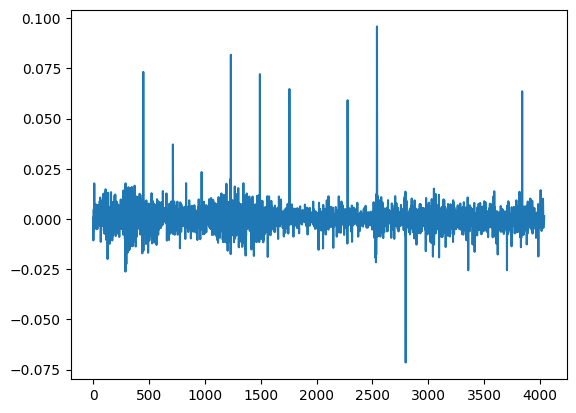

In [3]:
print(df2[["V","dlogV"]].describe())
print(df2["dlogV"].isna().mean())

gv = df2["gvkey"].iloc[0]
firm = df2[df2["gvkey"] == gv]
firm["dlogV"].plot()


In [4]:
import importlib, time
import nig_model_from_merton as nm
import nig_pd
importlib.reload(nig_pd)
importlib.reload(nm)

t0 = time.time()
params = nm.nig_fit_rolling_params_hybrid(df2, window=252, refit_every=20, winsor_p=0.001)
print("fit params (s):", round(time.time()-t0, 2))

t1 = time.time()
df_hybrid = nm.nig_attach_params_and_pd_hybrid(df2, params, horizon_years=1.0)
print("attach+PD (s):", round(time.time()-t1, 2))

df_hybrid["PD_nig_1y"].describe(percentiles=[.01,.05,.5,.95,.99])


fit params (s): 64.38
attach+PD (s): 89.62


count    1.719050e+05
mean     6.046534e-03
std      6.290104e-02
min      1.000000e-12
1%       1.000000e-12
5%       1.000000e-12
50%      1.625157e-06
95%      1.018977e-02
99%      5.323624e-02
max      1.000000e+00
Name: PD_nig_1y, dtype: float64

In [17]:
(df_hybrid["PD_nig_1y"] == 0).mean(), (df_hybrid["PD_nig_1y"] == 1).mean()
df_hybrid.loc[df_hybrid["PD_nig_1y"] > 0.999, ["gvkey","date","V","B","alpha","beta1","delta","beta0","PD_nig_1y"]].head(20)


,gvkey,date,V,B,alpha,beta1,delta,beta0,PD_nig_1y
58946,14140,2015-04-17,1.130150e+12,1.176582e+12,457.743962,20.397812,0.000712,0.000059,1.0
58947,14140,2015-04-20,1.130150e+12,1.176582e+12,457.743962,20.397812,0.000712,0.000059,1.0
58948,14140,2015-04-21,1.130150e+12,1.176582e+12,457.743962,20.397812,0.000712,0.000059,1.0
58949,14140,2015-04-22,1.130150e+12,1.176582e+12,457.743962,20.397812,0.000712,0.000059,1.0
58950,14140,2015-04-23,1.130150e+12,1.176582e+12,457.743962,20.397812,0.000712,0.000059,1.0
58951,14140,2015-04-24,1.130150e+12,1.176582e+12,457.743962,20.397812,0.000712,0.000059,1.0
58952,14140,2015-04-27,1.130150e+12,1.176582e+12,457.743962,20.397812,0.000712,0.000059,1.0
58953,14140,2015-04-28,1.130150e+12,1.176582e+12,457.743962,20.397812,0.000712,0.000059,1.0
58954,14140,2015-04-29,1.130150e+12,1.176582e+12,457.743962,20.397812,0.000712,0.000059,1.0
58955,14140,2015-04-30,1.130150e+12,1.176582e+12,457.743962,20.397812,0.000712,0.000059,1.0


In [ ]:
tmp = df_hybrid[df_hybrid["V"] > df_hybrid["B"]].copy()

tmp["diff"] = tmp["PD_nig_1y"] - tmp["PD_rn"]
tmp["log_ratio"] = np.log(tmp["PD_nig_1y"] + 1e-15) - np.log(tmp["PD_rn"] + 1e-15)

tmp[["diff","log_ratio"]].quantile([0.5,0.9,0.95,0.99])


,diff,log_ratio
0.50,1.545490e-08,3.993806
0.90,4.965431e-04,16.451888
0.95,1.305916e-03,18.785561
0.99,1.139398e-02,22.576498


In [19]:
df_hybrid.loc[stressed, ["PD_rn","PD_nig_1y"]].describe()


,PD_rn,PD_nig_1y
count,119.000000,119.000000
mean,0.969016,0.999856
std,0.010452,0.000263
min,0.942369,0.999295
25%,0.963554,0.999785
50%,0.964068,1.000000
75%,0.981741,1.000000
max,0.985110,1.000000


In [20]:
interesting = (df_hybrid["V"] > df_hybrid["B"]) & (df_hybrid["PD_nig_1y"] > df_hybrid["PD_rn"])
tmp = df_hybrid.loc[df_hybrid["V"] > df_hybrid["B"]].copy()
tmp["ratio"] = tmp["PD_nig_1y"] / np.maximum(tmp["PD_rn"], 1e-12)
tmp["ratio"].quantile([0.5,0.9,0.95,0.99])


0.50    1.365169e+01
0.90    4.635418e+05
0.95    3.308901e+06
0.99    4.845406e+07
Name: ratio, dtype: float64